In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

# Vinet Equation
def vinet_eq(V, P, V0, K0, K_prime):
    x = (V0 / V)**(1/3)
    term1 = (V0 / V)**(7/3) - (V0 / V)**(5/3)
    term2 = 1 + (3/4) * (K_prime - 4) * ((V0 / V)**(2/3) - 1)
    P_calc = (3 * K0 / 2) * term1 * term2
    return P_calc - P

def solve_volume(P, V0, K0, K_prime, alpha0, T, kappa):
    V_initial = V0 * (1 + alpha0 * (T - 298))
    
    def equation(V):
        eta = V / V0
        alpha = alpha0 * eta**kappa
        return vinet_eq(V, P, V0, K0, K_prime)
    
    V_solution, = fsolve(equation, V_initial)
    return V_solution

def cm3mol_to_m3mol(V_cm3mol):
    return V_cm3mol * 1e-6  


V0_solid_cm3mol = 12.256  # cm³/mol
V0_solid = cm3mol_to_m3mol(V0_solid_cm3mol)  # m³/mol
K0_solid = 149e9  # Pa
K_prime_solid = 3.83
alpha0_solid = 4.5e-5  # K^-1
kappa_solid = 1.4


V0_liquid_cm3mol = 13.16  # cm³/mol
V0_liquid = cm3mol_to_m3mol(V0_liquid_cm3mol)  # m³/mol
K0_liquid = 128e9  # Pa
K_prime_liquid = 3.85
alpha0_liquid = 4.7e-5  # K^-1
kappa_liquid = 1.4


data_points = [
    {'P_GPa': 11, 'T_K': 1950, 'Delta_Hm_kJmol': 41},
    {'P_GPa': 136, 'T_K': 3690, 'Delta_Hm_kJmol': 91},
    {'P_GPa': 200, 'T_K': 4129, 'Delta_Hm_kJmol': 103},
    {'P_GPa': 1000, 'T_K': 6100, 'Delta_Hm_kJmol': None},  
]


known_T = np.array([dp['T_K'] for dp in data_points if dp['Delta_Hm_kJmol'] is not None])
known_P = np.array([dp['P_GPa'] for dp in data_points if dp['Delta_Hm_kJmol'] is not None]) * 1e9  # Pa


fit_coeffs = np.polyfit(known_T, known_P, 1)  
poly_fit = np.poly1d(fit_coeffs)
dP_dT = fit_coeffs[0]  # Pa/K


print(f"P(T) = {fit_coeffs[0]:.4e} * T + {fit_coeffs[1]:.4e}")


for dp in data_points:
    if dp['Delta_Hm_kJmol'] is None:
        P = dp['P_GPa'] * 1e9  # GPa to Pa
        T = dp['T_K']
        V_solid = solve_volume(P, V0_solid, K0_solid, K_prime_solid, alpha0_solid, T, kappa_solid)
        V_liquid = solve_volume(P, V0_liquid, K0_liquid, K_prime_liquid, alpha0_liquid, T, kappa_liquid)
        Delta_Vm = V_liquid - V_solid  # m³/mol
        Delta_Hm = Delta_Vm * T * dP_dT  # J/mol
        Delta_Hm_kJmol = Delta_Hm / 1e3  # to kJ/mol
        
        dp['V_solid_m3mol'] = V_solid
        dp['V_liquid_m3mol'] = V_liquid
        dp['Delta_Vm_m3mol'] = Delta_Vm
        dp['Delta_Hm_Jmol'] = Delta_Hm
        dp['Delta_Hm_kJmol'] = Delta_Hm_kJmol

for dp in data_points:
    print(f" P = {dp['P_GPa']} GPa，T = {dp['T_K']} K ：")
    if dp['Delta_Hm_kJmol'] is not None:
        print(f"  Known ΔHm = {dp['Delta_Hm_kJmol']} kJ/mol")
    else:
        print(f"  Computed ΔHm = {dp['Delta_Hm_kJmol']:.2f} kJ/mol")
    if 'Delta_Vm_m3mol' in dp:
        print(f"  ΔVm = {dp['Delta_Vm_m3mol']:.4e} m³/mol\n")


P(T) = 8.2505e+07 * T + -1.5300e+11
 P = 11 GPa，T = 1950 K ：
  Known ΔHm = 41 kJ/mol
 P = 136 GPa，T = 3690 K ：
  Known ΔHm = 91 kJ/mol
 P = 200 GPa，T = 4129 K ：
  Known ΔHm = 103 kJ/mol
 P = 1000 GPa，T = 6100 K ：
  Known ΔHm = 650.6051351645161 kJ/mol
  ΔVm = 1.2927e-06 m³/mol



D:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\wenbo\AppData\Local\Temp\ipykernel_19540\3877363048.py:18: RuntimeWarning: invalid value encountered in power
  alpha = alpha0 * eta**kappa
C:\Users\wenbo\AppData\Local\Temp\ipykernel_19540\3877363048.py:7: RuntimeWarning: invalid value encountered in power
  x = (V0 / V)**(1/3)
C:\Users\wenbo\AppData\Local\Temp\ipykernel_19540\3877363048.py:8: RuntimeWarning: invalid value encountered in power
  term1 = (V0 / V)**(7/3) - (V0 / V)**(5/3)
C:\Users\wenbo\AppData\Local\Temp\ipykernel_19540\3877363048.py:9: RuntimeWarning: invalid value encountered in power
  term2 = 1 + (3/4) * (K_prime - 4) * ((V0 / V)**(2/3) - 1)
D:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured

74.91
66.55


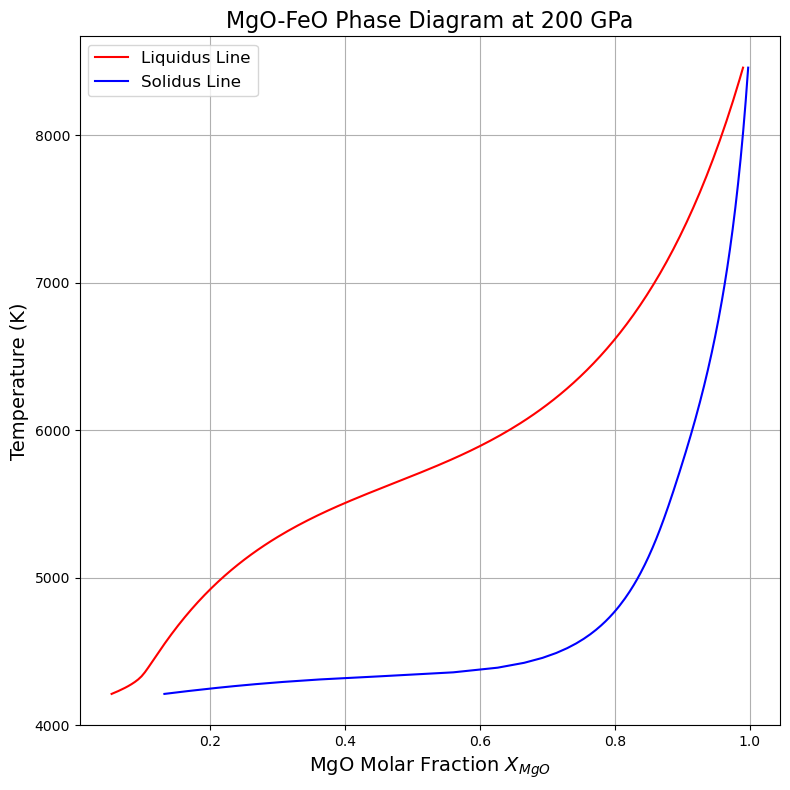

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Tm_MgO = 8624  # K
Tm_FeO = 4129  # K
delta_Hm_FeO = 103  # kJ/mol
delta_Hm_MgO = 28   # kJ/mol
P = 200  # GPa

W_liquid = -13.09 + 0.44 * P  # kJ/mol
W_solid = 20.55 + 0.23 * P   # kJ/mol

print(W_liquid)
print(W_solid)
R = 0.008314  # kJ/mol·K

def equations(vars, X_L):
    T, X_S = vars
    if X_L <= 0 or X_L >=1 or X_S <=0 or X_S >=1:
        return [1e6, 1e6]  
    try:
        eq1 = (delta_Hm_FeO * (1 - T / Tm_FeO) +
               W_liquid * X_L**2 -
               W_solid * X_S**2 +
               R * T * np.log((1 - X_L) / (1 - X_S)))
        
        eq2 = (delta_Hm_MgO * (1 - T / Tm_MgO) +
               W_liquid * (1 - X_L)**2 -
               W_solid * (1 - X_S)**2 +
               R * T * np.log(X_L / X_S))
        
        return [eq1, eq2]
    except:
        return [1e6, 1e6]  

X_L_values = np.linspace(0.01, 0.99, 200)  

X_L_list = []
T_list = []
X_S_list = []

initial_guess = [5000, 0.5]  # [T, X_S]

for X_L in X_L_values:
    try:
        solution, infodict, ier, mesg = fsolve(equations, initial_guess, args=(X_L,), full_output=True)
        T, X_S = solution
        
        if ier == 1 and 0 < X_S < 1 and 4000 < T < 9000:
            X_L_list.append(X_L)
            T_list.append(T)
            X_S_list.append(X_S)
            initial_guess = solution
        else:
            pass
    except:
        pass

if len(X_L_list) == 0:
    print("No Solution。")
else:
    plt.figure(figsize=(8, 8))
    plt.plot(X_L_list, T_list, label='Liquidus Line', color='red')
    plt.plot(X_S_list, T_list, label='Solidus Line', color='blue')
    plt.xlabel('MgO Molar Fraction $X_{MgO}$', fontsize=14)
    plt.ylabel('Temperature (K)', fontsize=14)
    plt.title('MgO-FeO Phase Diagram at 200 GPa', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('MgO_FeO_Phase_Diagram_200_GPa.png', dpi=300)
    plt.show()
    


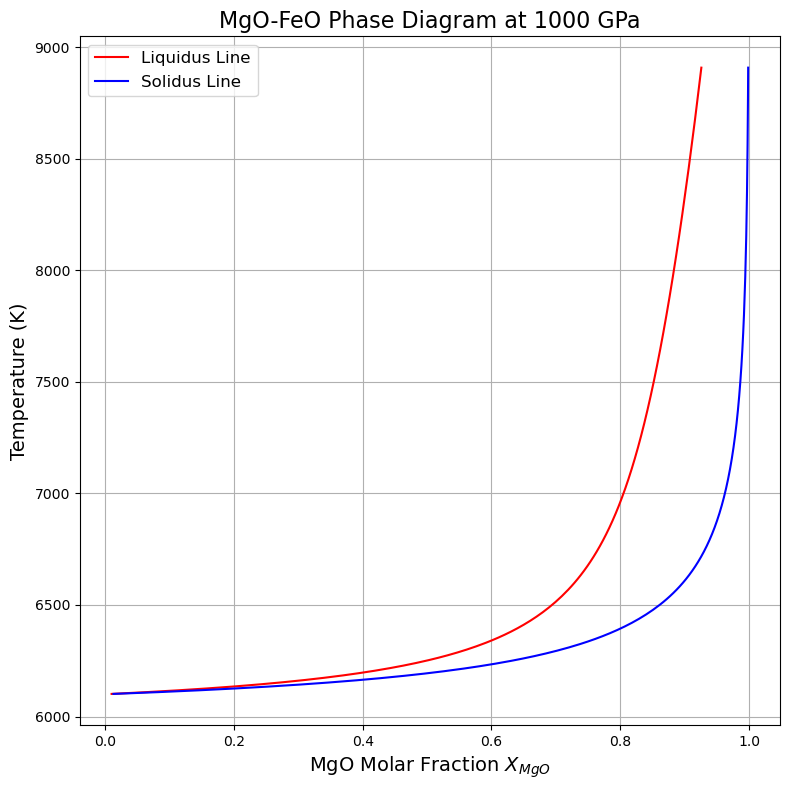

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Tm_MgO = 11136  # K
Tm_FeO = 6100  # K
delta_Hm_FeO = 650.6  # kJ/mol
delta_Hm_MgO = 28   # kJ/mol
P = 1000  # GPa


# W_liquid = -13.09 + 0.44 * P  # kJ/mol
# W_solid = 20.55 + 0.23 * P   # kJ/mol


W_liquid = 0  # kJ/mol
W_solid = 0   # kJ/mol
R = 0.008314  # kJ/mol·K

def equations(vars, X_L):
    T, X_S = vars
    if X_L <= 0 or X_L >=1 or X_S <=0 or X_S >=1:
        return [1e6, 1e6]  
    try:
        eq1 = (delta_Hm_FeO * (1 - T / Tm_FeO) +
               W_liquid * X_L**2 -
               W_solid * X_S**2 +
               R * T * np.log((1 - X_L) / (1 - X_S)))
        
        eq2 = (delta_Hm_MgO * (1 - T / Tm_MgO) +
               W_liquid * (1 - X_L)**2 -
               W_solid * (1 - X_S)**2 +
               R * T * np.log(X_L / X_S))
        
        return [eq1, eq2]
    except:
        return [1e6, 1e6]  


X_L_values = np.linspace(0.01, 0.99, 200)  

X_L_list = []
T_list = []
X_S_list = []

initial_guess = [5000, 0.5]  

for X_L in X_L_values:
    try:
        solution, infodict, ier, mesg = fsolve(equations, initial_guess, args=(X_L,), full_output=True)
        T, X_S = solution
        if ier == 1 and 0 < X_S < 1 and 4000 < T < 9000:
            X_L_list.append(X_L)
            T_list.append(T)
            X_S_list.append(X_S)
            initial_guess = solution
        else:
            pass
    except:
        pass


if len(X_L_list) == 0:
    print("No Solution。")
else:
    plt.figure(figsize=(8, 8))
    plt.plot(X_L_list, T_list, label='Liquidus Line', color='red')
    plt.plot(X_S_list, T_list, label='Solidus Line', color='blue')
    plt.xlabel('MgO Molar Fraction $X_{MgO}$', fontsize=14)
    plt.ylabel('Temperature (K)', fontsize=14)
    plt.title('MgO-FeO Phase Diagram at 1000 GPa', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('MgO_FeO_Phase_Diagram_1000_GPa.png', dpi=300)
    plt.show()
    